# Import packages

### Import python packages

In [62]:
import re,os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from IPython.display import clear_output
import pandas as pd
import math
import random
from datetime import datetime
from tqdm import trange
import matplotlib.colors as mcolors
tfk = tf.keras
tfkl = tf.keras.layers
clear_output()

### Import custom packages

In [2]:
from symae_model import SymAE
from plot_save import plot_save
from generate import generate
from plot_training import plot_training
from redatuming import redatuming
from plot_redatuming import plot_redatuming

Num GPUs Available:  2
TensorFlow Version:  2.9.1


# Generate the Dataset

### Set parameters

n1 = $n_\varepsilon$  
n2 = number of nuisances  
nx = $n_X$  
nt = $n_\tau$   
states = all states I will use  
nuisances = all nuisances I will use

In [133]:
n1 = 10 
n2 = 10
nx = 16
nt = 5
p = 5
q = 15
dropout_rate = 0
states = np.arange(n1)+1
nuisances = np.arange(n2)+1

### Generate X

In [138]:
try:
    nx*nt <= n1*n2
except:
    print('X is larger than D')
data = generate(states,nuisances,nx,nt,outer_replace=False)
X = data.X
X_states = data.X_states
X_nuisances = data.X_nuisances

### What blocks in D is selected by X?

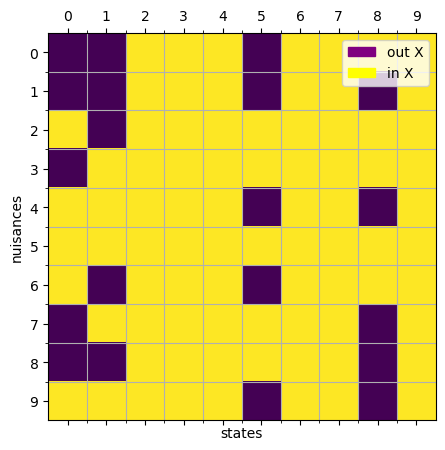

In [139]:
waiting_samples = data.waiting_samples
D_selected = np.ones((n1,n2))
for i in range(n1):
    for j in range(n2):
        D_selected[i][waiting_samples[i]] = 0    
plt.figure(figsize=(5,5),dpi=100)
plt.matshow(D_selected.T, fignum=1)
purple_patch = mpatches.Patch(color='purple', label='out X')
yellow_patch = mpatches.Patch(color='yellow', label='in X')
plt.legend(handles=[purple_patch,yellow_patch])
plt.ylabel('nuisances')
plt.xlabel('states')
plt.xticks(range(n1))
plt.yticks(range(n2))
plt.gca().set_xticks([x - 0.5 for x in plt.gca().get_xticks()][1:], minor='true')
plt.gca().set_yticks([y - 0.5 for y in plt.gca().get_yticks()][1:], minor='true')
plt.grid(which='minor')
plt.show()

# Train SymAE

### Initialize SymAE

In [140]:
model = SymAE(nx,nt,p,q,dropout_rate)
model.load_weights('./checkpoint/'+datetime.now().strftime("%B%d"))
#model.load_weights('./checkpoint/'+'June20')
clear_output()

### Select optimizer

In [144]:
Adam = tf.keras.optimizers.Adam(learning_rate=0.0001,beta_1=0.9,beta_2=0.999,epsilon=1e-07)
model.compile(loss='mse',optimizer=Adam)

### Train the NeuralNet

In [145]:
M=1000
epochs=range(M)
losses=[0.0]*M
class CustomCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        clear_output(wait=True)
        losses[epoch]=logs["loss"]
        print("For epoch {:d}, loss is {:f}.".format(epoch, logs["loss"]))
history=model.fit(X,X,epochs=M,verbose=0,callbacks=[CustomCallback()])

For epoch 999, loss is 0.000371.


### Loss-epoch graph

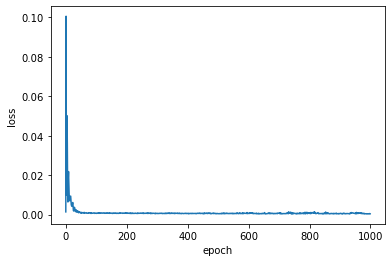

In [146]:
plt.plot(epochs,losses)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

### Save weights

In [147]:
# Save weights
model.save_weights('./checkpoint/'+datetime.now().strftime("%B%d"))
print("weights saved")

weights saved


# Matplot training loss

### Creat a dict mapping from subscripts of D to subscripts of X

In [148]:
subscript_map = {}
for i in range(nx):
    for j in range(nt):
        subscript_map[(X_states[i],X_nuisances[i,j])] = (i,j)

### Plot D and SymAE(X)

1/1 [==============================] - 0s 37ms/step


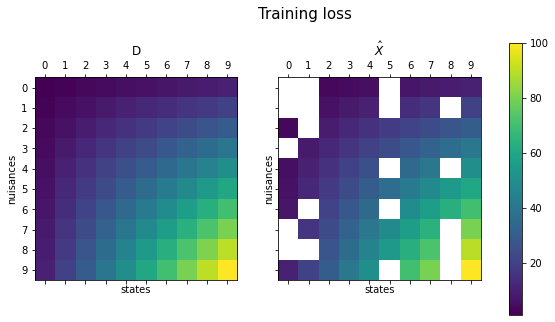

In [175]:
D = data.D
X_hat = model.predict(X)[:,:,0]
X_converted = np.empty((n1,n2))
X_converted.fill(np.inf)
for i in range(nx):
    for j in range(nt):
        i_D = X_states[i]
        j_D = X_nuisances[i,j]
        X_converted[i_D,j_D] = X_hat[i,j]
def plot_reconstruct(D,X_converted):
    fig, axs = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(10,5))
    norm = mcolors.Normalize(vmin=np.amin(D), vmax=np.amax(D))
    pcm = axs[0].matshow(D.T, norm = norm)
    axs[0].set_ylabel('nuisances')
    axs[0].set_xlabel('states')
    axs[0].set_xticks(range(n1))
    axs[0].set_yticks(range(n2))
    axs[0].set_title('D')
    pcm = axs[1].matshow(X_converted.T, norm = norm)
    axs[1].set_ylabel('nuisances')
    axs[1].set_xlabel('states')
    axs[1].set_xticks(range(n1))
    axs[1].set_yticks(range(n2))
    axs[1].set_title('$\hat{X}$')
    fig.colorbar(pcm,ax=axs)
    return fig
fig = plot_reconstruct(D,X_converted)
fig.suptitle('Training loss',fontsize=15)
plt.show()

# Performance of reconstructing D

### Evaluate latent code

In [159]:
Cs = model.sym_encoder.predict(X, verbose=0)
Ns = model.nui_encoder.predict(X, verbose=0)

### Creat a dict, mapping from coordinates of missing blocks (in D) to coordinates i, i', j (in X)

In [164]:
flag = True 
#If flag==True, then do redatuming for all blocks
#If flag==False, then do redatuming only for blank blocks
missing_map = {}
for i_D in range(n1):
    for j_D in range(n2):
        if X_converted[i_D,j_D] == np.inf or flag:
            state_candidates = np.argwhere(X_states==i_D)
            nuisance_candidates = np.argwhere(X_nuisances==j_D)
            i_s, = state_candidates[np.random.choice(state_candidates.shape[0])]
            i_n, j_n = nuisance_candidates[np.random.choice(nuisance_candidates.shape[0])]
            missing_map[i_D,j_D] = (i_n,i_s,j_n)

### Fill out X_converted

In [165]:
X_redatum = np.copy(X_converted)
coherent_i_prime = np.empty((1,p))
nuisance_i_j = np.empty((1,q*nt))
for (i_D,j_D) in missing_map.keys():
    i,i_prime,j = missing_map[i_D,j_D]
    coherent_i_prime=Cs[i_prime:i_prime+1,:]
    nuisance_i_j=Ns[i_prime:i_prime+1,:]
    merger = model.latentcat(coherent_i_prime,nuisance_i_j)
    X_redatum[i_D,j_D] = model.decoder.predict(merger, verbose=0)[0,j,0]

### Plot

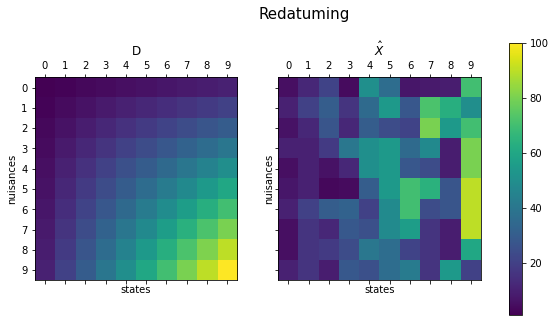

In [172]:
fig = plot_reconstruct(D,X_redatum)
fig.suptitle('Redatuming',fontsize=15)
plt.show()

# Others (not using)

### Plot the result

In [ ]:
Y = model.predict(X)
i = 0
fig = plot_training(X,Y,i)
plt.title('i=%d, state=%d'%(0,X_states[0]))

### Save plot

In [ ]:
plot_save(fig,ID=-1)

## Readtuming

### Z_hat[i,i',j] is $\hat{X}_{i \to i'}[j]$. Z is what we expect Z_hat to be


In [ ]:
Z, Z_hat = redatuming(model,data)

### Plot redatuming for specific i and i'

In [ ]:
i = 0
i_prime = 1
fig = plot_redatuming(Z,Z_hat,X_states,i,i_prime)

### Save plot

In [ ]:
plot_save(fig,ID=-1)